# Sentiment Analysis in torchtext

### Imports

In [1]:
'''
    Reference - https://github.com/hpanwar08/sentiment-analysis-torchtext/blob/master/Sentiment_Analysis_torchtext.ipynb
'''
%matplotlib inline
import os, sys
import re
import string
import pathlib
import random
from collections import Counter, OrderedDict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from tqdm import tqdm, tqdm_notebook, tnrange
tqdm.pandas(desc='Progress')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

import torchtext
from torchtext import data
from torchtext import vocab

from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import accuracy_score

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'

import warnings
warnings.filterwarnings('ignore')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
print('Python version:',sys.version)
print('Pandas version:',pd.__version__)
print('Pytorch version:', torch.__version__)
print('Torch Text version:', torchtext.__version__)
print('Spacy version:', spacy.__version__)

Python version: 3.6.7 |Anaconda, Inc.| (default, Oct 23 2018, 19:29:21) 
[GCC 7.3.0]
Pandas version: 0.23.4
Pytorch version: 0.4.0
Torch Text version: 0.3.1
Spacy version: 2.0.16


### Load data

In [3]:
data_root = pathlib.Path('./data/raw/')

classes = ['Auto', 'Bank', 'Blog', 'Business Interview',
           'Economy', 'Education', 'Employment', 'Entertainment',
           'Interview', 'Literature', 'National News', 'Opinion',
           'Sports', 'Technology', 'Tourism', 'World']

In [4]:
df = pd.read_csv('./data/raw/train.csv', error_bad_lines=False)
df.shape
df.head()

(10594, 2)

,label,data
0,10,थारु सभासदहरुले कैलालीको टीकापुरमा भएको झडपमा ...
1,10,राजविराज चैत सप्तरी प्रहरीले पातो गाविसबाट स...
2,1,गजेन्द्र बुढाथोकीकाठमाडौं माघ बैंकिङ क्षेत्र...
3,10,उपप्रधानमन्त्री कमल थापाले संविधानमा असहमति हु...
4,10,असोज काठमाडौं अमेरिकी अधिकारीहरुले आधिकारिक ...


In [5]:
df = df.rename(index=str, columns={"data": "SentimentText", "label": "Sentiment"})

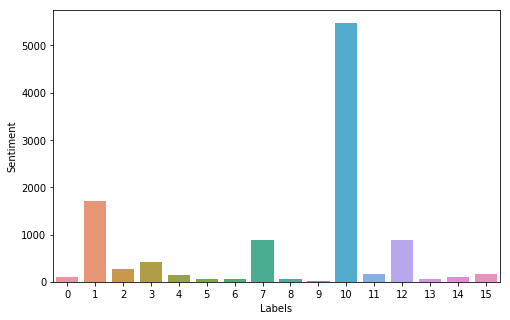

In [6]:
fig = plt.figure(figsize=(8,5))
ax = sns.barplot(x=df.Sentiment.unique(), y=df.Sentiment.value_counts());
ax.set(xlabel='Labels');

## Train validation split

##### torchtext have trouble handling \n. Replace \n character with space.

In [7]:
df['SentimentText'] = df.SentimentText.progress_apply(lambda x: re.sub('\n', ' ', x))

Progress: 100%|██████████| 10594/10594 [00:00<00:00, 191369.46it/s]


In [8]:
def split_train_test(df, test_size=0.2):
    train, val = train_test_split(df, test_size=test_size,random_state=42)
    return train.reset_index(drop=True), val.reset_index(drop=True)

In [9]:
traindf, valdf = split_train_test(df, test_size=0.2)

In [10]:
traindf.shape
traindf.Sentiment.value_counts()

(8475, 2)

10    4363
12    1365
7      719
4      697
11     342
1      216
2      134
14     126
15     116
6       88
3       84
13      56
5       54
8       53
0       52
9       10
Name: Sentiment, dtype: int64

In [11]:
valdf.shape
valdf.Sentiment.value_counts()

(2119, 2)

10    1111
12     341
4      181
7      162
11      77
1       54
15      37
14      34
2       27
3       24
6       20
0       16
8       12
5       11
13       9
9        3
Name: Sentiment, dtype: int64

##### Save the train and validation df

In [12]:
traindf.to_csv(data_root/'traindf.csv', index=False)
valdf.to_csv(data_root/'valdf.csv', index=False)

## 1. Define how to process data

##### Preprocessing

In [13]:
nlp = spacy.load('en',disable=['parser', 'tagger', 'ner'])
def tokenizer(s): return [w.text.lower() for w in nlp(tweet_clean(s))]

In [14]:
def tweet_clean(text):
    text = re.sub(r'[^A-Za-z0-9]+', ' ', text) # remove non alphanumeric character
    text = re.sub(r'https?:/\/\S+', ' ', text) # remove links
    return text.strip()

In [15]:
def tokenizer(s): return s.split()

##### Define fields

In [16]:
txt_field = data.Field(sequential=True, tokenize=tokenizer, include_lengths=True, use_vocab=True)
label_field = data.Field(sequential=False, use_vocab=False, pad_token=None, unk_token=None)

train_val_fields = [
    ('Sentiment', label_field),
    ('SentimentText', txt_field)
]

## 2. Create torchtext dataset

In [17]:
%%time
trainds, valds = data.TabularDataset.splits(path=data_root, format='csv', train='traindf.csv', validation='valdf.csv', fields=train_val_fields, skip_header=True)

CPU times: user 1.04 s, sys: 28 ms, total: 1.06 s
Wall time: 1.06 s


In [18]:
len(trainds), len(valds)

(8475, 2119)

In [ ]:
ex = trainds[0]
trainds.fields.items()
# ex.Sentiment
# ex.SentimentText

dict_items([('Sentiment', <torchtext.data.field.Field object at 0x3ffcf48ffb38>), ('SentimentText', <torchtext.data.field.Field object at 0x3ffcf48ffba8>)])

'10'

['बैशाख',
 'चितवन',
 'चितवनमा',
 'सञ्चालित',
 'अधिकांश',
 'ड्राइभिङ',
 'सेन्टरहरु',
 'नियमविपरीत',
 'सञ्चालन',
 'भइरहेको',
 'फेला',
 'परेका',
 'छन्',
 'जसमध्ये',
 'मापदण्ड',
 'विपरित',
 'विना',
 'नविकरण',
 'र',
 'दर्ता',
 'नभएका',
 'धेरै',
 'रहेकोे',
 'पाईएको',
 'हो',
 'त्यस्तै',
 'प्रशिक्षण',
 'दिने',
 'प्रशिक्षकको',
 'सवारी',
 'चालक',
 'अनुमतिपत्र',
 'नभएको',
 'अनुभवी',
 'नभएको',
 'जिल्ला',
 'ट्राफिक',
 'कार्यालय',
 'चितवनले',
 'जनाएको',
 'छ',
 'सवारी',
 'तथा',
 'यातायात',
 'व्यवस्था',
 'ऐनअनुसार',
 'यातायात',
 'व्यवस्था',
 'विभागमा',
 'दर्ता',
 'गरेर',
 'मात्रै',
 'सञ्चालन',
 'गर्न',
 'पाउने',
 'कानुनी',
 'प्रावधान',
 'भए',
 'पनि',
 'यस्ता',
 'ड्राइभिङ',
 'सेन्टरहरु',
 'विभागमा',
 'दर्ता',
 'नगरी',
 'गैरकानुनी',
 'रुपमा',
 'सञ्चालन',
 'भएको',
 'पाइएको',
 'छ',
 'कतिपय',
 'नविकरण',
 'नै',
 'गरेका',
 'छैनन्',
 'चितवनमा',
 'रहेका',
 'ड्राइभिङ',
 'सेन्टरका',
 'संञ्चालकहरुलाई',
 'सवारी',
 'दुर्घटना',
 'र',
 'सवारी',
 'आवत',
 'जावतमा',
 'सहजता',
 'पुर्याउने',
 'उद्देश्यले',
 'जिल्ला',
 'ट्

In [ ]:
# ex = valds[0]
# ex.Sentiment

## 3. Load pretrained word vectors and building vocabulary

In [ ]:
%%time
# vec = vocab.Vectors('glove.twitter.27B.100d.txt', './data/glove_embedding/')
vec = vocab.Vectors('./data/large_nep2vec.txt')

CPU times: user 136 ms, sys: 24 ms, total: 160 ms
Wall time: 161 ms


In [ ]:
%%time
txt_field.build_vocab(trainds, valds, max_size=100000, vectors=vec)
label_field.build_vocab(trainds)

CPU times: user 2.5 s, sys: 0 ns, total: 2.5 s
Wall time: 2.49 s


In [ ]:
txt_field.vocab.vectors.shape

torch.Size([100002, 100])

In [ ]:
txt_field.vocab.vectors[txt_field.vocab.stoi['म']]

tensor([-0.3896,  1.8487, -0.0657,  2.0903,  0.4955, -0.6503, -2.4989,
        -1.6274, -1.0375,  2.6434, -0.8152, -0.2311, -1.8350,  2.2657,
         1.6724,  0.2105, -0.0679,  0.1389,  1.7299,  1.6670,  2.4800,
        -1.7672,  0.3998, -1.1306,  2.3462,  1.5662,  0.6138, -2.6506,
        -2.4233, -2.7957, -1.5976,  2.4225, -2.1781, -0.1329,  2.0305,
         0.4357,  0.8959,  0.2567,  2.7800,  1.6513,  1.5992,  0.5938,
         1.6162, -1.7877,  1.6819, -0.0324, -1.5037, -3.1891,  0.8827,
        -0.2825, -0.7122,  1.1246,  1.4272,  0.8021, -4.1194,  1.4679,
        -2.7505,  1.1685,  3.3379, -0.6846,  1.1243,  2.1203, -1.1586,
        -3.2750, -0.9348,  3.7749,  3.0786, -1.0205,  2.5531, -0.5501,
        -1.1917, -0.0792, -0.7715,  0.3274,  2.7693,  3.8868,  1.0523,
        -1.4871,  0.0718, -0.2615, -0.7815,  1.9536,  0.1851,  0.4665,
         4.1067,  1.0190, -1.7467,  1.5418, -1.7004, -1.5643, -1.1541,
         0.6280, -0.4386,  0.9448,  2.8460,  1.9715, -1.5069, -2.0099,
      

## 4. Loading the data in batches

In [ ]:
traindl, valdl = data.BucketIterator.splits(datasets=(trainds, valds), 
                                            batch_sizes=(3,3), 
                                            sort_key=lambda x: len(x.SentimentText), 
                                            device=None, 
                                            sort_within_batch=True, 
                                            repeat=False)

In [ ]:
len(traindl), len(valdl)

(2825, 707)

In [ ]:
batch = next(iter(traindl))
type(batch)

torchtext.data.batch.Batch

In [ ]:
batch.Sentiment

tensor([ 11,  11,  10])

##### returns word indices and lengths

In [ ]:
batch.SentimentText

(tensor([[    94,  22469,    473],
         [   310,   3066,     56],
         [     2,   4988,  37241],
         ...,
         [    22,      1,      1],
         [  1201,      1,      1],
         [     0,      1,      1]]), tensor([ 1704,  1609,  1539]))

In [ ]:
batch.dataset.fields

{'Sentiment': <torchtext.data.field.Field at 0x3ffcf48ffb38>,
 'SentimentText': <torchtext.data.field.Field at 0x3ffcf48ffba8>}

In [ ]:
txt_field.vocab.itos[1]

'<pad>'

##### convert index to string

Function to convert batch to text

In [ ]:
def idxtosent(batch, idx):
    return ' '.join([txt_field.vocab.itos[i] for i in batch.SentimentText[0][:,idx].cpu().data.numpy()])

In [ ]:
idxtosent(batch,0)

'एउटा भनाइ छ मानिसहरु पहिलो नजरमै प्रेममा पर्ने गर्छन् र उनीहरुको माया अनन्तकालसम्म रहिरहन्छ यद्यपि यो मायाले न त घर बनाउन मिल्छ न भविश्य नै बनाउन सकिन्छ वा भनौं कसैलाई रोगबाट नै फर्काउन सकिन्छ मेरो विचार यी महिला हुन् जसले सम्बन्ध बनाउँछन् तपाईहरुलाई थाहा छ म पुरुषहरुलाई किन परामर्श दिन्न किनकि ती पुरुषहरुले जहिल्यै मलाई महिला गलत हुन्छन् भन्ने प्रमाणित गर्ने कोशिश गर्छन् उनीहरुले एउटा <unk> अपेक्षा गर्ने पनि त्यति नै हो मेरो विचारमा पुरुषहरु महिलामाथि प्रतिक्रिया मात्र जनाउँछन् उनीहरुले त्यही किसिमको प्रतिक्रिया <unk> भने देखाउँदैनन् त्यसैले मैले <unk> काम गर्नुको एउटैमात्र कारण के हो भने म <unk> विश्वास गर्छु कि जब महिलाहरु परिवर्तन हुन्छन् त्यतिबेला पुरुषसितको <unk> सम्बन्ध पनि परिवर्तन हुन्छ यो लेखमा तपाईहरुले महिलाका सात साधारण त्रुटीहरु थाहा पाउन सक्नुहुन्छ जुन मैले सामना गर्दै आएकी छु तपाई भाषण धेरै <unk> बनाउने क्रममा हुने मुख्य गल्ती भनेको महिलाहरुले गर्ने वादविवाद नै हो यसको मतलव मैले नचाहिँदो गफ भन्न खोजेको हैन बरु म किन निराश छु भन्नुको साटो त्यसलाई तन्काएर म भन्छु यो कसरी

In [ ]:
val_batch = next(iter(valdl))

##### Note that BucketIterator returns a Batch object instead of text index and labels directly and Batch object is not iterable unlike pytorch Dataloader. A single Batch object contains the data of one batch and the text and labels can be accessed via column names. 
##### This is one of the small hiccups in torchtext. But this can be easily overcome in two ways. Either write some extra code in the training loop for getting the data out of Batch object or write a iterable wrapper around Batch Object that returns the desired data. I will take the second approach as this is much cleaner.

In [ ]:
class BatchGenerator:
    def __init__(self, dl, x_field, y_field):
        self.dl, self.x_field, self.y_field = dl, x_field, y_field
        
    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        for batch in self.dl:
            X = getattr(batch, self.x_field)
            y = getattr(batch, self.y_field)
            yield (X,y)

In [ ]:
train_batch_it = BatchGenerator(traindl, 'SentimentText', 'Sentiment')

## 5. Finally Model and training

In [ ]:
vocab_size = len(txt_field.vocab)
embedding_dim = 100
n_hidden = 64
n_out = len(classes)

## Simple RNN module

#### Simple GRU model

In [ ]:
class SimpleGRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_hidden, n_out, pretrained_vec, bidirectional=True):
        super().__init__()
        self.vocab_size,self.embedding_dim,self.n_hidden,self.n_out,self.bidirectional = vocab_size, embedding_dim, n_hidden, n_out, bidirectional
        self.emb = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.emb.weight.data.copy_(pretrained_vec)
        self.emb.weight.requires_grad = False
        self.gru = nn.GRU(self.embedding_dim, self.n_hidden, bidirectional=bidirectional)
        self.out = nn.Linear(self.n_hidden, self.n_out)
        
    def forward(self, seq, lengths):
        bs = seq.size(1) # batch size
        seq = seq.transpose(0,1)
        self.h = self.init_hidden(bs) # initialize hidden state of GRU
        embs = self.emb(seq)
        embs = embs.transpose(0,1)
        embs = pack_padded_sequence(embs, lengths) # unpad
        gru_out, self.h = self.gru(embs, self.h) # gru returns hidden state of all timesteps as well as hidden state at last timestep
        gru_out, lengths = pad_packed_sequence(gru_out) # pad the sequence to the max length in the batch
        # since it is as classification problem, we will grab the last hidden state
        outp = self.out(self.h[-1]) # self.h[-1] contains hidden state of last timestep
#         return F.log_softmax(outp, dim=-1)
        return F.log_softmax(outp)
    
    def init_hidden(self, batch_size): 
        if self.bidirectional:
            return torch.zeros((2,batch_size,self.n_hidden)).to(device)
        else:
            return torch.zeros((1,batch_size,self.n_hidden)).to(device)

In [ ]:
class SimpleRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_hidden, n_out, pretrained_vec, bidirectional=True):
        super().__init__()
        self.vocab_size,self.embedding_dim,self.n_hidden,self.n_out,self.bidirectional = vocab_size, embedding_dim, n_hidden, n_out, bidirectional
        self.emb = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.emb.weight.data.copy_(pretrained_vec)
        self.emb.weight.requires_grad = False
        self.rnn = nn.RNN(self.embedding_dim, self.n_hidden, bidirectional=bidirectional)
        self.out = nn.Linear(self.n_hidden, self.n_out)
        
    def forward(self, seq, lengths):
        bs = seq.size(1) # batch size
        seq = seq.transpose(0,1)
        self.h = self.init_hidden(bs) # initialize hidden state of GRU
        embs = self.emb(seq)
        embs = embs.transpose(0,1)
        embs = pack_padded_sequence(embs, lengths) # unpad
        rnn_out, self.h = self.rnn(embs, self.h) # gru returns hidden state of all timesteps as well as hidden state at last timestep
        rnn_out, lengths = pad_packed_sequence(rnn_out) # pad the sequence to the max length in the batch
        # since it is as classification problem, we will grab the last hidden state
        outp = self.out(self.h[-1]) # self.h[-1] contains hidden state of last timestep
#         return F.log_softmax(outp, dim=-1)
        return F.log_softmax(outp)
    
    def init_hidden(self, batch_size): 
        if self.bidirectional:
            return torch.zeros((2,batch_size,self.n_hidden)).to(device)
        else:
            return torch.zeros((1,batch_size,self.n_hidden)).to(device)

#### Concat Pooling model

In [ ]:
class ConcatPoolingGRUAdaptive(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_hidden, n_out, pretrained_vec, bidirectional=True):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.n_hidden = n_hidden
        self.n_out = n_out
        self.bidirectional = bidirectional
        
        self.emb = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.emb.weight.data.copy_(pretrained_vec)
        self.emb.weight.requires_grad = False
        self.gru = nn.GRU(self.embedding_dim, self.n_hidden, bidirectional=bidirectional)
        if bidirectional:
            self.out = nn.Linear(self.n_hidden*2*2, self.n_out)
        else:
            self.out = nn.Linear(self.n_hidden*2, self.n_out)
        
    def forward(self, seq, lengths):
        bs = seq.size(1)
        self.h = self.init_hidden(bs)
        seq = seq.transpose(0,1)
        embs = self.emb(seq)
        embs = embs.transpose(0,1)
        embs = pack_padded_sequence(embs, lengths)
        gru_out, self.h = self.gru(embs, self.h)
        gru_out, lengths = pad_packed_sequence(gru_out)        
        
        avg_pool = F.adaptive_avg_pool1d(gru_out.permute(1,2,0),1).view(bs,-1)
        max_pool = F.adaptive_max_pool1d(gru_out.permute(1,2,0),1).view(bs,-1)        
        outp = self.out(torch.cat([avg_pool,max_pool],dim=1))
        return F.log_softmax(outp)
    
    def init_hidden(self, batch_size): 
        if self.bidirectional:
            return torch.zeros((2,batch_size,self.n_hidden)).to(device)
        else:
            return torch.zeros((1,batch_size,self.n_hidden)).cuda().to(device)

#### Training function

In [ ]:
def fit(model, train_dl, val_dl, loss_fn, opt, epochs=3):
    num_batch = len(train_dl)
    for epoch in tnrange(epochs):      
        y_true_train = list()
        y_pred_train = list()
        total_loss_train = 0          
        
        t = tqdm_notebook(iter(train_dl), leave=False, total=num_batch)
        for (X,lengths),y in t:
            t.set_description(f'Epoch {epoch}')
            lengths = lengths.cpu().numpy()
            
            opt.zero_grad()
            pred = model(X, lengths)
            loss = loss_fn(pred, y)
            loss.backward()
            opt.step()
            
            t.set_postfix(loss=loss.item())
            pred_idx = torch.max(pred, dim=1)[1]
            
            y_true_train += list(y.cpu().data.numpy())
            y_pred_train += list(pred_idx.cpu().data.numpy())
            total_loss_train += loss.item()
            
        train_acc = accuracy_score(y_true_train, y_pred_train)
        train_loss = total_loss_train/len(train_dl)
        
        if val_dl:
            y_true_val = list()
            y_pred_val = list()
            total_loss_val = 0
            for (X,lengths),y in tqdm_notebook(val_dl, leave=False):
                pred = model(X, lengths.cpu().numpy())
                loss = loss_fn(pred, y)
                pred_idx = torch.max(pred, 1)[1]
                y_true_val += list(y.cpu().data.numpy())
                y_pred_val += list(pred_idx.cpu().data.numpy())
                total_loss_val += loss.item()
            valacc = accuracy_score(y_true_val, y_pred_val)
            valloss = total_loss_val/len(valdl)
            print(f'Epoch {epoch}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f} | val_loss: {valloss:.4f} val_acc: {valacc:.4f}')
        else:
            print(f'Epoch {epoch}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f}')

##### Dataloader

In [ ]:
traindl, valdl = data.BucketIterator.splits(datasets=(trainds, valds), 
                                            batch_sizes=(512,1024), 
                                            sort_key=lambda x: len(x.SentimentText), 
                                            device=device, 
                                            sort_within_batch=True, 
                                            repeat=False)

train_batch_it = BatchGenerator(traindl, 'SentimentText', 'Sentiment')
val_batch_it = BatchGenerator(valdl, 'SentimentText', 'Sentiment')

##### Train simple GRU model

In [ ]:
m = SimpleGRU(vocab_size, embedding_dim, n_hidden, n_out, trainds.fields['SentimentText'].vocab.vectors).to(device)
opt = optim.Adam(filter(lambda p: p.requires_grad, m.parameters()), 1e-3)

fit(model=m, train_dl=train_batch_it, val_dl=val_batch_it, loss_fn=F.nll_loss, opt=opt, epochs=10)

Epoch 0: train_loss: 2.2293 train_acc: 0.4018 | val_loss: 1.9871 val_acc: 0.5243


Epoch 1: train_loss: 1.6790 train_acc: 0.5147 | val_loss: 1.9180 val_acc: 0.5252


Epoch 2: train_loss: 1.5752 train_acc: 0.5227 | val_loss: 1.8561 val_acc: 0.5517


Epoch 3: train_loss: 1.5100 train_acc: 0.5375 | val_loss: 1.8241 val_acc: 0.5706


Epoch 4: train_loss: 1.4253 train_acc: 0.5776 | val_loss: 1.7423 val_acc: 0.5861


Epoch 5: train_loss: 1.3483 train_acc: 0.6021 | val_loss: 1.6688 val_acc: 0.6177


Epoch 6: train_loss: 1.2647 train_acc: 0.6235 | val_loss: 1.6211 val_acc: 0.6479


Epoch 7: train_loss: 1.1931 train_acc: 0.6454 | val_loss: 1.5379 val_acc: 0.6612


Epoch 8: train_loss: 1.1396 train_acc: 0.6628 | val_loss: 1.4948 val_acc: 0.6701


Epoch 9: train_loss: 1.0853 train_acc: 0.6782 | val_loss: 1.4731 val_acc: 0.6758



In [ ]:
m = SimpleRNN(vocab_size, embedding_dim, n_hidden, n_out, trainds.fields['SentimentText'].vocab.vectors).to(device)
opt = optim.Adam(filter(lambda p: p.requires_grad, m.parameters()), 1e-3)

fit(model=m, train_dl=train_batch_it, val_dl=val_batch_it, loss_fn=F.nll_loss, opt=opt, epochs=20)

Epoch 0: train_loss: 2.2181 train_acc: 0.4034 | val_loss: 1.9638 val_acc: 0.5191


Epoch 1: train_loss: 1.6963 train_acc: 0.5117 | val_loss: 1.9212 val_acc: 0.5281


Epoch 2: train_loss: 1.5977 train_acc: 0.5188 | val_loss: 1.8818 val_acc: 0.5290


Epoch 3: train_loss: 1.5520 train_acc: 0.5283 | val_loss: 1.8594 val_acc: 0.5432


Epoch 4: train_loss: 1.5148 train_acc: 0.5469 | val_loss: 1.8311 val_acc: 0.5606


Epoch 5: train_loss: 1.4809 train_acc: 0.5647 | val_loss: 1.8145 val_acc: 0.5701


Epoch 6: train_loss: 1.4511 train_acc: 0.5716 | val_loss: 1.7983 val_acc: 0.5767


Epoch 7: train_loss: 1.4191 train_acc: 0.5794 | val_loss: 1.7708 val_acc: 0.5847


Epoch 8: train_loss: 1.3847 train_acc: 0.5908 | val_loss: 1.7776 val_acc: 0.5927


Epoch 9: train_loss: 1.3591 train_acc: 0.5936 | val_loss: 1.7536 val_acc: 0.5927


Epoch 10: train_loss: 1.3310 train_acc: 0.5928 | val_loss: 1.6519 val_acc: 0.6022


Epoch 11: train_loss: 1.2814 train_acc: 0.6057 | val_loss: 1.6474 val_acc: 0.6234


Epoch 12: train_loss: 1.2446 train_acc: 0.6165 | val_loss: 1.5954 val_acc: 0.6182


Epoch 13: train_loss: 1.2344 train_acc: 0.6189 | val_loss: 1.5302 val_acc: 0.6380


Epoch 14: train_loss: 1.1905 train_acc: 0.6319 | val_loss: 1.5241 val_acc: 0.6465


Epoch 15: train_loss: 1.1983 train_acc: 0.6291 | val_loss: 1.5353 val_acc: 0.6300


Epoch 16: train_loss: 1.1787 train_acc: 0.6402 | val_loss: 1.4889 val_acc: 0.6352


Epoch 17: train_loss: 1.1487 train_acc: 0.6500 | val_loss: 1.5026 val_acc: 0.6286


Epoch 18: train_loss: 1.1330 train_acc: 0.6553 | val_loss: 1.4786 val_acc: 0.6494


Epoch 19: train_loss: 1.1090 train_acc: 0.6575 | val_loss: 1.4753 val_acc: 0.6541



##### Train Concat Pooling model

In [ ]:
m = ConcatPoolingGRUAdaptive(vocab_size, embedding_dim, n_hidden, n_out, trainds.fields['SentimentText'].vocab.vectors).to(device)
opt = optim.Adam(filter(lambda p: p.requires_grad, m.parameters()), 1e-3)

fit(model=m, train_dl=train_batch_it, val_dl=val_batch_it, loss_fn=F.nll_loss, opt=opt, epochs=10)

Epoch 0: train_loss: 2.1182 train_acc: 0.4093 | val_loss: 2.0165 val_acc: 0.5243


Epoch 1: train_loss: 1.6402 train_acc: 0.5175 | val_loss: 2.0020 val_acc: 0.5347


Epoch 2: train_loss: 1.5374 train_acc: 0.5343 | val_loss: 1.9732 val_acc: 0.5625


Epoch 3: train_loss: 1.4337 train_acc: 0.5758 | val_loss: 1.8883 val_acc: 0.5880


Epoch 4: train_loss: 1.3491 train_acc: 0.6099 | val_loss: 1.7501 val_acc: 0.5828
